# Clusters de sapatos

## Introdução

Um dos maiores problemas do e-commerce é agrupar produtos baseado na visão do usuário e não em características como cor, preço e fabricante. Uma necessidade é corrigir preços.

Uma das formas de atacar este problema é usando as features conhecidas (preço, cores, fabricante, categorias da estrutura mercadológica, etc) para gerar um vetor que represente o produto, e encontrar clusters que os agrupem usando alguma métrica de distância vetorial.

Vamos atacar este problema com um dataset de sapatos.

## Dados

Temos um conjunto de dados de registros de vendas de sapatos, cada sapato está identificado por um *id* único, e as linhas o apresentam em diversas ofertas de lojas onlne com cores, a categorização do site em que é ofertado, condição da oferta (novo ou usado), marca e preço cobrado.

In [1]:
import pandas as pd
df = pd.read_json("shoes.json", orient="records", lines=True)

In [2]:
df.count()

brand         10000
categories    10000
colors        10000
condition     10000
id            10000
isSale        10000
price         10000
dtype: int64

In [3]:
df.shape

(10000, 7)

In [4]:
df.head(10)

,brand,categories,colors,condition,id,isSale,price
0,Naturalizer,"[Clothing, Heels, Shoes, Women's Shoes, All Wo...","[Silver, Cream]",USED,AVpfEf_hLJeJML431ueH,False,55.990
1,MUK LUKS,"[Clothing, Shoes, Women's Shoes, All Women's S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,True,41.125
2,MUK LUKS,"[Clothing, Shoes, Women's Shoes, All Women's S...",[Grey],NEW,AVpi74XfLJeJML43qZAc,False,35.250
3,MUK LUKS,"[Clothing, Women's Slippers, Shoes, Women's Sh...",[Black],NEW,AVpjXyCc1cnluZ0-V-Gj,False,24.750
4,MUK LUKS,"[Clothing, Women's Slippers, Shoes, Women's Sh...",[Grey],NEW,AVphGKLPilAPnD_x1Nrm,True,31.695
5,Soft Ones,"[Clothing, Shoes, Baby & Kids Shoes, Women's S...",[Brown],NEW,AVpg91ziilAPnD_xziOo,True,10.950
6,MUK LUKS,"[Women's Casual Shoes, Clothing, Women's Slipp...","[Purple, Brown, Navy, Burgundy, Light, Black, ...",USED,AVpjGKXyLJeJML43r8BH,False,18.395
7,MUK LUKS,"[Women's Casual Shoes, Clothing, Women's Slipp...","[Purple, Brown, Navy, Burgundy, Light, Black, ...",USED,AVpjGKXyLJeJML43r8BH,False,18.395
8,MUK LUKS,"[Women's Shoes, All Women's Shoes, Shoes, Clot...","[Navy, Grey]",NEW,AVpfLXyhilAPnD_xWmNc,True,49.440
9,MUK LUKS,"[Clothing, Shoes, Women's Shoes, All Women's S...",[Brown],NEW,AVpfeWdJ1cnluZ0-lXYU,True,53.495


As colunas seguintes estão presentes:

* id: Código identificador de cada sapato
* brand: Marca do sapato
* categories: Categorias em que o sapato foi alocado no e-commerce onde a oferta é apresentada
* colors: Cores disponíveis
* condition: Se está usado ou novo.
* price: Preço cobrado pelo e-commerce em que está sendo ofertado.

## Desafio

1. Você deve usar o algoritmo de sua preferência para agrupar os sapatos de acordo com *condition*, *categories* e *colors* disponíveis gerando 4 clusters.

2. Para cada cluster encontrado, você deve calcular o preço médio e o desvio padrão de preço.

3. Como bônus, você pode apresentar os clusters num gráfico, mas essa etapa não é obrigatória.

Para tanto, tenha em mente as seguintes observações:

1. Um produto pode ser ofertado em mais de uma loja, portanto, pode aparecer mais de uma vez no conjunto de dados e ter valores para *categories*, *colors* e *condition* diferentes, você precisa reunir estes dados e criar um único registro para cada id.

2. Campos como *brand*, *categories*, *colors* e *condition* são **categóricos**, dependêndo do algoritmo utilizado você vai precisar aplicar alguma técnica como [codificação one-hot](https://medium.com/@arthurlambletvaz/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0) quando (e se) for utilizá-los.

### Inicialização - Import, gráficos

In [5]:
import numpy as np
import seaborn as sns
#import missingno as msno
import gc

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [7]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [8]:
df.columns

Index(['brand', 'categories', 'colors', 'condition', 'id', 'isSale', 'price'], dtype='object')

In [9]:
df.dtypes

brand          object
categories     object
colors         object
condition      object
id             object
isSale           bool
price         float64
dtype: object

In [10]:
display(df.describe())

,price
count,10000.00
mean,60.18
std,18.79
min,5.38
25%,49.99
50%,56.88
75%,67.49
max,359.95


In [11]:
#missingValueColumns = df.columns[df.isnull().any()].tolist()
#df_null = df[missingValueColumns] 

In [12]:
#missingValueColumns


In [13]:
df.isnull().sum()

brand         0
categories    0
colors        0
condition     0
id            0
isSale        0
price         0
dtype: int64

## One-hot Encoding effect


### Definição da lista de features categóricas que queremos processar

Converter atributos categóricos em valores binários com one-hot-encode para utilização do k-means, que é o algoritmo escolhido para esta análise.

No Aprendizado de Máquina não supervisionado, o conjunto de dados de entrada é composto por exemplos não rotulados.Não  existe uma classe associada a cada exemplo. Nesse caso, são utilizados algoritmos de aprendizado (no nosso caso o k-means) para descobrir padrões nos dados a partir de alguma caracterização ou de regularidade. Assim, a tarefa consiste em agrupar uma coleção de exemplos segundo alguma medida de similaridade de modo que exemplos pertencentes ao mesmo cluster devem ser mais similares entre si e menos similares aos exemplos pertencentes a clusters diferentes.

In [14]:
one_hot_columns = ["brand","condition"]

In [15]:
df_processed = pd.get_dummies(df, prefix_sep="__",columns=one_hot_columns)

In [16]:
df_processed.shape

(10000, 136)

In [17]:
df_processed=df_processed.drop(["categories","colors"], axis=1)

In [18]:
df_processed.head(10)

,id,isSale,price,brand__2 lips too,brand__Adidas,brand__Adidas Outdoor,brand__Altra,brand__Arc'teryx,brand__Asics,brand__Astral,...,brand__soft style by hush puppies,brand__sonoma goods for life,brand__spring step,brand__style charles by charles david,brand__sugar,brand__under armour,brand__unionbay,brand__vans,condition__NEW,condition__USED
0,AVpfEf_hLJeJML431ueH,False,55.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,AVpi74XfLJeJML43qZAc,True,41.12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,AVpi74XfLJeJML43qZAc,False,35.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AVpjXyCc1cnluZ0-V-Gj,False,24.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,AVphGKLPilAPnD_x1Nrm,True,31.70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,AVpg91ziilAPnD_xziOo,True,10.95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,AVpjGKXyLJeJML43r8BH,False,18.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,AVpjGKXyLJeJML43r8BH,False,18.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,AVpfLXyhilAPnD_xWmNc,True,49.44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,AVpfeWdJ1cnluZ0-lXYU,True,53.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Para categories e colors, que são uma lista de informações para cada, utilizei os seguintes comandos de dados

In [19]:
df_processed1 = pd.get_dummies(pd.DataFrame(df["categories"].values.tolist()), prefix="categories" , prefix_sep='__').groupby(axis=1, level=0).max()
df_processed2 = pd.get_dummies(pd.DataFrame(df["colors"].values.tolist()), prefix="colors" , prefix_sep='__').groupby(axis=1, level=0).max()


In [20]:
df_processed1.shape

(10000, 124)

In [21]:
df_processed2.shape


(10000, 223)

### Base de dados completa com todos as features categóricas utilizando one-hot-enconde

## Temos uma base com 10000 rows × 481 columns

In [22]:
df_processed3 = pd.concat([df_processed,df_processed1,df_processed2], axis=1)

In [23]:
df_processed3.head(10)

,id,isSale,price,brand__2 lips too,brand__Adidas,brand__Adidas Outdoor,brand__Altra,brand__Arc'teryx,brand__Asics,brand__Astral,...,colors__Virtual,colors__Wheat,colors__White,colors__Whitebrooke,colors__Whitefire,colors__Whitegrey,colors__Whitewhite,colors__Wine,colors__Wood,colors__Yellow
0,AVpfEf_hLJeJML431ueH,False,55.99,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AVpi74XfLJeJML43qZAc,True,41.12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AVpi74XfLJeJML43qZAc,False,35.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AVpjXyCc1cnluZ0-V-Gj,False,24.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AVphGKLPilAPnD_x1Nrm,True,31.70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,AVpg91ziilAPnD_xziOo,True,10.95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AVpjGKXyLJeJML43r8BH,False,18.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AVpjGKXyLJeJML43r8BH,False,18.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AVpfLXyhilAPnD_xWmNc,True,49.44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AVpfeWdJ1cnluZ0-lXYU,True,53.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_processed3.columns

Index(['id', 'isSale', 'price', 'brand__2 lips too', 'brand__Adidas',
       'brand__Adidas Outdoor', 'brand__Altra', 'brand__Arc'teryx',
       'brand__Asics', 'brand__Astral',
       ...
       'colors__Virtual', 'colors__Wheat', 'colors__White',
       'colors__Whitebrooke', 'colors__Whitefire', 'colors__Whitegrey',
       'colors__Whitewhite', 'colors__Wine', 'colors__Wood', 'colors__Yellow'],
      dtype='object', length=481)

In [25]:
df_processed3=df_processed3.groupby('id').apply(lambda x: x.sort_values('id'))

In [26]:
df_processed3.head(10)

id  isSale  price  \
id                                                               
AV-9hndsuC1rwyj_g2bb 4956  AV-9hndsuC1rwyj_g2bb   False  70.49   
                     4988  AV-9hndsuC1rwyj_g2bb   False  79.99   
                     4989  AV-9hndsuC1rwyj_g2bb   False  89.99   
                     4990  AV-9hndsuC1rwyj_g2bb   False  89.99   
                     4991  AV-9hndsuC1rwyj_g2bb   False  64.99   
                     4992  AV-9hndsuC1rwyj_g2bb   False  66.24   
                     4993  AV-9hndsuC1rwyj_g2bb   False  71.24   
                     4994  AV-9hndsuC1rwyj_g2bb   False  66.24   
                     4995  AV-9hndsuC1rwyj_g2bb   False  89.99   
                     4996  AV-9hndsuC1rwyj_g2bb   False  79.99   

                           brand__2 lips too  brand__Adidas  \
id                                                            
AV-9hndsuC1rwyj_g2bb 4956                  0              0   
                     4988                  0              0   
                     4989                  0              0   
                     4990                  0              0   
                     4991                  0              0   
                     4992                  0              0   
                     4993                  0              0   
                     4994                  0              0   
                     4995                  0              0   
                     4996                  0              0   

                           brand__Adidas Outdoor  brand__Altra  \
id                                                               
AV-9hndsuC1rwyj_g2bb 4956                      0             0   
                     4988                      0             0   
                     4989                      0             0   
                     4990                      0             0   
                     4991                      0             0   
                     4992                      0             0   
                     4993                      0             0   
                     4994                      0             0   
                     4995                      0             0   
                     4996                      0             0   

                           brand__Arc'teryx  brand__Asics  brand__Astral  \
id                                                                         
AV-9hndsuC1rwyj_g2bb 4956                 0             0              0   
                     4988                 0             0              0   
                     4989                 0             0              0   
                     4990                 0             0              0   
                     4991                 0             0              0   
                     4992                 0             0              0   
                     4993                 0             0              0   
                     4994                 0             0              0   
                     4995                 0             0              0   
                     4996                 0             0              0   

                                ...        colors__Virtual  colors__Wheat  \
id                              ...                                         
AV-9hndsuC1rwyj_g2bb 4956       ...                      0              0   
                     4988       ...                      0              0   
                     4989       ...                      0              0   
                     4990       ...                      0              0   
                     4991       ...                      0              0   
                     4992       ...                      0              0   
                     4993       ...                      0              0   
                     4994       ...                      0              0   
                   

### DROP resgitros duplicados

In [27]:
df_processed3=df_processed3.drop_duplicates()

In [28]:
df_processed3.shape


(2126, 481)

In [29]:
display(df_processed3.describe())

,price,brand__2 lips too,brand__Adidas,brand__Adidas Outdoor,brand__Altra,brand__Arc'teryx,brand__Asics,brand__Astral,brand__Birkenstock,brand__Bogs,...,colors__Virtual,colors__Wheat,colors__White,colors__Whitebrooke,colors__Whitefire,colors__Whitegrey,colors__Whitewhite,colors__Wine,colors__Wood,colors__Yellow
count,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,...,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00,2126.00
mean,61.29,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,23.45,0.05,0.07,0.03,0.06,0.03,0.05,0.03,0.04,0.02,...,0.04,0.02,0.16,0.02,0.03,0.02,0.02,0.04,0.03,0.02
min,5.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,48.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,57.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,69.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,359.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Normalizando a coluna price do dataframe df através da fórmula

## (x-min(x)/max(x)-min(x)

In [30]:
min_price=df_processed3['price'].min()
max_price=df_processed3['price'].max()
count_price=df_processed3['price'].count()

In [31]:
df_processed3['price_norm'] = df_processed3['price'].apply(lambda x: (x-min_price)/(max_price-min_price))

In [32]:
listcol = []

for col in df_processed3.columns: 
    listcol.append(col)


In [33]:
df_processed3.head(10)

id  isSale  price  \
id                                                               
AV-9hndsuC1rwyj_g2bb 4956  AV-9hndsuC1rwyj_g2bb   False  70.49   
                     4988  AV-9hndsuC1rwyj_g2bb   False  79.99   
                     4989  AV-9hndsuC1rwyj_g2bb   False  89.99   
                     4991  AV-9hndsuC1rwyj_g2bb   False  64.99   
                     4992  AV-9hndsuC1rwyj_g2bb   False  66.24   
                     4993  AV-9hndsuC1rwyj_g2bb   False  71.24   
                     4998  AV-9hndsuC1rwyj_g2bb   False  74.99   
                     5006  AV-9hndsuC1rwyj_g2bb   False  72.99   
                     5009  AV-9hndsuC1rwyj_g2bb   False  69.99   
AV-9ho2OKZqtpbFMTHo1 7387  AV-9ho2OKZqtpbFMTHo1   False  77.49   

                           brand__2 lips too  brand__Adidas  \
id                                                            
AV-9hndsuC1rwyj_g2bb 4956                  0              0   
                     4988                  0              0   
                     4989                  0              0   
                     4991                  0              0   
                     4992                  0              0   
                     4993                  0              0   
                     4998                  0              0   
                     5006                  0              0   
                     5009                  0              0   
AV-9ho2OKZqtpbFMTHo1 7387                  0              0   

                           brand__Adidas Outdoor  brand__Altra  \
id                                                               
AV-9hndsuC1rwyj_g2bb 4956                      0             0   
                     4988                      0             0   
                     4989                      0             0   
                     4991                      0             0   
                     4992                      0             0   
                     4993                      0             0   
                     4998                      0             0   
                     5006                      0             0   
                     5009                      0             0   
AV-9ho2OKZqtpbFMTHo1 7387                      0             0   

                           brand__Arc'teryx  brand__Asics  brand__Astral  \
id                                                                         
AV-9hndsuC1rwyj_g2bb 4956                 0             0              0   
                     4988                 0             0              0   
                     4989                 0             0              0   
                     4991                 0             0              0   
                     4992                 0             0              0   
                     4993                 0             0              0   
                     4998                 0             0              0   
                     5006                 0             0              0   
                     5009                 0             0              0   
AV-9ho2OKZqtpbFMTHo1 7387                 0             0              0   

                              ...      colors__Wheat  colors__White  \
id                            ...                                     
AV-9hndsuC1rwyj_g2bb 4956     ...                  0              0   
                     4988     ...                  0              0   
                     4989     ...                  0              0   
                     4991     ...                  0              0   
                     4992     ...                  0              0   
                     4993     ...                  0              0   
                     4998     ...                  0              0   
                     5006     ...                  0              0   
                     5009     ...                  0              0   
AV-9ho2O

Solução implementada abaixo:

#### Clustering (Agrupamento): Aprendizado não Supervisionado

#### Algoritmo K-MEANS

Utilizarei o algoritmo de clustering K-Means para identificar as várias segmentações de clientes escondidos nos dados.

O K-means tem as seguintes características:

- Não temos labels no nosso conjunto de dados
- Agrupar os dados em grupos semelhantes entre si de modo a tirar informações relevantes disso
- Etapa para etiquetar os dados para um algoritmo de aprendizado supervisionado
- Usar K centroides em localizações aleatórias
- Utilizar 4 agrupamentos ou clusters (brand, categories,colors, condition)


In [34]:
# K-MEANS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
X = np.array(df_processed3[['price_norm', 'brand__2 lips too', 'brand__Adidas','brand__Adidas Outdoor','brand__Altra',"brand__Arc'teryx",\
                            'brand__Asics', 'brand__Astral', 'brand__Birkenstock', 'brand__Bogs', 'brand__Brinley Co.',\
                            'brand__Brinley Co. Collection','brand__Brooks','brand__Carrini', 'brand__Chaco', \
                            'brand__Daniel Green', 'brand__Danskin Now', 'brand__Dansko', "brand__Dr. Scholl's",\
                            'brand__ELLIE SHOES','brand__Earth Spirit','brand__Easy Street', 'brand__FOREVER YOUNG',\
                            'brand__Faded Glory','brand__Fergalicious','brand__Free People', 'brand__Frye',\
                            'brand__Genuine Dickies','brand__Hoka One One','brand__IB Non-Slip',\
                            'brand__Inov 8','brand__KEEN','brand__Kaanas','brand__Keds',\
                            'brand__La Sportiva',\
                            'brand__Laredo',\
                            'brand__Lifestride',\
                            'brand__Lowa',\
                            'brand__Lugz',\
                            'brand__MLB',\
                            'brand__MUK LUKS',\
                            'brand__Merrell',\
                            'brand__Mo Mo',\
                            'brand__Native Shoes',\
                            'brand__Naturalizer',\
                            'brand__New Balance',\
                            'brand__Nike',\
                            'brand__OTZShoes',\
                            'brand__Olukai',\
                            'brand__On Footwear',\
                            'brand__Red Wing',\
                            'brand__Riverberry',\
                            'brand__Ryka',\
                            'brand__SKECHERS',\
                            'brand__Salewa',\
                            'brand__Salomon',\
                            'brand__Saucony',\
                            'brand__Scarpa',\
                            'brand__SeaVees',\
                            'brand__Seychelles Footwear',\
                            'brand__Silver Lilly',\
                            'brand__Sloggers',\
                            'brand__Soft Ones',\
                            'brand__SoftWalk',\
                            'brand__Soludos',\
                            'brand__Sperry Top-Sider',\
                            'brand__Splendid',\
                            'brand__The North Face',\
                            'brand__Timberland',\
                            'brand__Toms',\
                            'brand__Topo Athletic',\
                            'brand__UGG',\
                            'brand__Unbranded',\
                            'brand__Under Armour',\
                            'brand__Unique Bargains',\
                            'brand__Vans',\
                            'brand__Victoria K.',\
                            'brand__a2 by aerosoles',\
                            'brand__adidas',\
                            'brand__andrew geller','brand__apt. 9','brand__asics',\
                            'brand__betula by birkenstock',\
                            'brand__candies',\
                            'brand__clarks',\
                            'brand__corkys',\
                            'brand__croft barrow',\
                            'brand__dolce by mojo moxy',\
                            'brand__dr. scholls',\
                            'brand__eastland',\
                            'brand__easy street',\
                            'brand__fila',\
                            'brand__forever collectibles',\
                            'brand__henry ferrera',\
                            'brand__herstar',\
                            'brand__jennifer lopez',\
                            'brand__journee collection',\
                            'brand__k-swiss',\
                            'brand__keds',\
                            'brand__kisses by 2 lips too',\
                            'brand__koolaburra by ugg',\
                            'brand__lc lauren conrad',\
                            'brand__lifestride',\
                            'brand__lugz',\
                            'brand__madden nyc',\
                            'brand__muk luks',\
                            'brand__naturalsoul by naturalizer',\
                            'brand__new balance',\
                            'brand__nike',\
                            'brand__nyla',\
                            'brand__olivia miller',\
                            'brand__puma',\
                            'brand__qupid',\
                            'brand__rampage',\
                            'brand__reef',\
                            'brand__rocky 4eursole',\
                            'brand__ryka',\
                            'brand__seven7',\
                            'brand__simply vera vera wang',\
                            'brand__skechers',\
                            'brand__so',\
                            'brand__soft style by hush puppies',\
                            'brand__sonoma goods for life',\
                            'brand__spring step',\
                            'brand__style charles by charles david',\
                            'brand__sugar',\
                            'brand__under armour',\
                            'brand__unionbay',\
                            'brand__vans',\
                            'condition__NEW',\
                            'condition__USED',\
'categories__2 Lips Too',\
'categories__A2 by Aerosoles',\
 'categories__ASICS',\
 "categories__All Men's Shoes",\
 "categories__All Women's Shoes",\
 'categories__All Womens Shoes',\
 'categories__Andrew Geller',\
 'categories__Apt. 9',\
 'categories__Athletic',\
 'categories__Athletic Shoes',\
 'categories__Baby & Kids Shoes',\
 'categories__Baby & Toddler Shoes',\
 'categories__Barrow',\
 'categories__Betula by Birkenstock',\
 'categories__Boat Shoes',\
 'categories__Boots',\
 "categories__Boys' Shoes",\
 "categories__Candie's",\
 'categories__Clarks',\
 'categories__Clogs',\
 'categories__Clothing',\
 'categories__Comfort',\
 'categories__Corkys',\
 'categories__Cowboy Boots',\
 'categories__Croft',\
 'categories__Dolce by Mojo Moxy',\
 "categories__Dr. Scholl's",\
 'categories__Eastland',\
 'categories__Easy Street',\
 'categories__FILA',\
 'categories__Fergalicious',\
 'categories__Fitness',\
 'categories__Flats',\
 'categories__Forever Collectibles',\
 "categories__Girls' Boots",\
 "categories__Girls' Shoes",\
 'categories__Heels',\
 'categories__Henry Ferrera',\
 'categories__Herstar',\
 'categories__Home Improvement',\
 'categories__Jennifer Lopez',\
 'categories__Journee Collection',\
 'categories__K-Swiss',\
 'categories__Keds',\
 'categories__Kisses by 2 Lips Too',\
 'categories__Koolaburra by UGG',\
 'categories__LC Lauren Conrad',\
 'categories__Laredo',\
 'categories__LifeStride',\
 'categories__Loafers',\
 'categories__Low Slide Sandals',\
 'categories__Lugz',\
 'categories__MUK LUKS',\
 "categories__Men's Athletic Shoes",\
 "categories__Men's Casual Shoes",\
 "categories__Men's Shoes",\
 'categories__Mid-Calf Boots',\
 'categories__Mules',\
 'categories__NYLA',\
 'categories__NaturalSoul by naturalizer',\
 'categories__New Balance',\
 'categories__Nike',\
 'categories__Olivia Miller',\
 'categories__Other Slip-Ons',\
 'categories__Oxfords',\
 'categories__PUMA',\
 'categories__Pumps',\
 'categories__Qupid',\
 'categories__REEF',\
 'categories__Rampage',\
 'categories__Rocky 4EurSole',\
 'categories__Running & Yoga',\
 'categories__Ryka',\
 'categories__SONOMA Goods for Life',\
 'categories__Sandals',\
 'categories__Sandals & Flip Flops',\
 'categories__Seven7',\
 'categories__Shoes',\
 'categories__Shoes & Accessories',\
 'categories__Shop by Clothing Type',\
 'categories__Simply Vera Vera Wang',\
 'categories__Skechers',\
 'categories__Slip-ons',\
 'categories__Slippers',\
 'categories__Sneakers',\
 'categories__Soft Style by Hush Puppies',\
 'categories__Sporting Goods',\
 'categories__Spring Step',\
 'categories__Style Charles by Charles David',\
 'categories__Under Armour',\
 'categories__Unionbay',\
 'categories__Vans',\
 'categories__Women',\
 "categories__Women's Athletic Shoes",\
 "categories__Women's Boots",\
 "categories__Women's Casual Boots & Shoes",\
 "categories__Women's Casual Shoes",\
 "categories__Women's Clothing",\
 "categories__Women's Dress Shoes",\
 "categories__Women's Footwear",\
 "categories__Women's New Balance Shoes",\
 "categories__Women's Red Wing Shoes",\
 "categories__Women's Road Running Shoes",\
 "categories__Women's Running Shoes",\
 "categories__Women's Sandals",\
 "categories__Women's Shoes",\
 "categories__Women's Slippers",\
 "categories__Women's Trail Running Shoes",\
 "categories__Women's Wear to Work",\
 "categories__Women's Winter Boots",\
 "categories__Women's Work & Safety Shoes",\
 'categories__Womens',\
 'categories__Womens Casual Shoes',\
 'categories__Womens Comfort',\
 'categories__Womens Comfort Boots & Booties',\
 'categories__Womens Oxford & Loafers',\
 'categories__Womens Oxfords',\
 'categories__Womens Sandals & Flip Flops',\
 'categories__Womens Shoes',\
 'categories__Womens Sport Sandals',\
 'categories__Work Safety Clothing and Equipment',\
 'categories__adidas',\
 'categories__madden NYC',\
 'categories__sugar',\
'colors__Angora','colors__Anthracitedark','colors__Antique',\
'colors__AquariumFlashCoralBlueJewel','colors__Aquifer',\
'colors__Armory','colors__Aruba','colors__Asphalt',\
'colors__Atomic','colors__Azalea', 'colors__Basalt',
'colors__Bayou','colors__Beaujolaiswhite','colors__Beige',\
'colors__Birch','colors__Bird','colors__Black','colors__Black-Purple-Print',\
'colors__Blackblack','colors__Blackchrome-Aurora','colors__Blackcotton',\
'colors__Blackfrost','colors__Blackgreen','colors__Blackgreenbrown',\
'colors__Blackgrey','colors__Blackmetallic','colors__Blacksilver',\
'colors__Blacksmoky','colors__Blackwatch','colors__Blackwhite',\
'colors__Bleach','colors__Blue','colors__Blueblue',\
'colors__Blueprint','colors__Bomber','colors__Bone',\
'colors__Bordo','colors__Brindle','colors__Bronze',\
'colors__Brooke',\
'colors__Brown',\
'colors__Brownbark',\
'colors__Brunette',\
'colors__Buckskin',\
'colors__Burgundy',\
'colors__Cabana',\
'colors__Calypso',\
'colors__Capri',\
'colors__Caraibes',\
'colors__Carbon',\
'colors__Cashew',\
'colors__Castlerock',\
'colors__Ceramic',\
'colors__Charcoal',\
'colors__Charcoalcreamgumblue-Black',\
'colors__Cherries',\
'colors__Chestnut',\
'colors__Chocolate',\
'colors__Clematis',\
'colors__Coffee',\
'colors__Cognac',\
'colors__Cool',\
'colors__Coral',\
'colors__Coraltaupe',\
'colors__Core',\
'colors__Coreblack',\
'colors__Cream',\
'colors__Dark',\
'colors__Deep',\
'colors__Diva',\
'colors__Easy',\
'colors__Ebony-Silver-Pink',\
'colors__Eggplant',\
'colors__Emerald',\
'colors__Evening',\
'colors__Fabric',\
'colors__Fair',\
'colors__Fatigue',\
'colors__Fiji',\
'colors__Fjord',\
'colors__Flamingo',\
'colors__Floral',\
'colors__Footwear',\
'colors__Frost',\
'colors__Fuchsia',\
'colors__Fusion',\
'colors__Glacier',\
'colors__Gold',\
'colors__Golden',\
'colors__Gore',\
'colors__Gray',\
'colors__Graysilver',\
'colors__Grey',\
'colors__Greyblack',\
'colors__Greypurple',\
'colors__Gunsmoke',\
'colors__Habana',\
'colors__Hawaiian',\
'colors__Highrisewhite',\
'colors__Honey',\
'colors__Hot',\
'colors__Ice',\
'colors__Indigo',\
'colors__Inkdeadly',\
'colors__Insignia',\
'colors__Ivory',\
'colors__Jiffy',\
'colors__Khaki',\
'colors__Kiwi',\
'colors__Koa',\
'colors__Leopard',\
'colors__Liberty',\
'colors__Licorice',\
'colors__Light',\
'colors__Lilac',\
'colors__Luggage',\
'colors__Lux',\
'colors__Luxe',\
'colors__Madder',\
'colors__Mahogany',\
'colors__Marine',\
'colors__Marlin',\
'colors__Maroon',\
'colors__Mauve',\
'colors__Me',\
'colors__Medieval',\
'colors__Medium',\
'colors__Metallic',\
'colors__Mica',\
'colors__Mint',\
'colors__Moccasin',\
'colors__Mocha',\
'colors__Mojolica',\
'colors__Morning',\
'colors__Multi-Color',\
'colors__Mushroom',\
'colors__Mustang',\
'colors__N',\
'colors__NA',\
'colors__Nasturtium',\
'colors__Natural',\
'colors__Naturalgold',\
'colors__Navy',\
'colors__Navy-Plum-Ice',\
'colors__Navy-Teal-Mint',\
'colors__Navyblue',\
'colors__Neon',\
'colors__Neutral',\
'colors__Nobile',\
'colors__Noble',\
'colors__Nude',\
'colors__Olive',\
'colors__Orange',\
'colors__Orchid',\
'colors__Oro',\
'colors__Oyster',\
'colors__Peach',\
'colors__Pearl',\
'colors__Pewter',\
'colors__Pewterchampagne',\
'colors__Pigeon',\
'colors__Pink',\
'colors__Pinot',\
'colors__Platinum',\
'colors__Poseidon',\
'colors__Premier',\
'colors__Primer',\
'colors__Punch',\
'colors__Pure',\
'colors__Purple',\
'colors__Purple-Pink-Teal',\
'colors__Purpleblack',\
'colors__Quarry',\
'colors__Rainbow',\
'colors__Raspberry',\
'colors__Raspberrywhite',\
'colors__Raw',\
'colors__Red',\
'colors__Redpink',\
'colors__Redyellow',\
'colors__Reflecting',\
'colors__Regatta',\
'colors__Rose',\
'colors__Sage',\
'colors__Sand',\
'colors__Sangria',\
'colors__Silver',\
'colors__Slate',\
'colors__Slateblue',\
'colors__Soft',\
'colors__Steel',\
'colors__Stingraywhite',\
'colors__Stone',\
'colors__Summit',\
'colors__Super',\
'colors__Sweet',\
'colors__Tan',\
'colors__Tanwhite',\
'colors__Taupe',\
'colors__Teal',\
'colors__Team',\
'colors__Tibet',\
'colors__Tibetan',\
'colors__Tideline',\
'colors__Tobacco',\
'colors__Tornado',\
'colors__True',\
'colors__Turbulence',\
'colors__Turquo',\
'colors__Turquoise',\
'colors__Twilight',\
'colors__Utility',\
'colors__Vintage',\
'colors__Virtual',\
'colors__Wheat',\
'colors__White',\
'colors__Whitebrooke',\
'colors__Whitefire',\
'colors__Whitegrey',\
'colors__Whitewhite',\
'colors__Wine',\
'colors__Wood',\
'colors__Yellow']])


In [36]:
X.shape

(2126, 478)

In [37]:
y = np.array(df_processed3['price'])

In [38]:
y.shape

(2126,)

In [39]:
# Aplicar o algoritmo de clustering de sua escolha aos dados reduzidos 
n_clusters=4
kmeans = KMeans(n_clusters, random_state=29).fit(X)

# Prever o cluster para cada ponto de dado
preds = kmeans.predict(X)

# Os centroides do cluster
centers = kmeans.cluster_centers_

# TPrever o cluster para cada amostra de pontos de dado transformados
#sample_preds = kmeans.predict(X)

# Calcular a média do coeficiente de silhueta para o número de clusters escolhidos
score = silhouette_score(X, kmeans.labels_, metric='euclidean')
print ("KMeans score para Brand (n_clusters=",n_clusters,") score=", score)

KMeans score para Brand (n_clusters= 4 ) score= 0.18589282198468327


In [40]:
centers

array([[ 1.60880698e-01, -2.77555756e-17, -5.98479599e-17, ...,
        -1.38777878e-17, -4.01154804e-18, -2.00577402e-18],
       [ 3.05105791e-01,  6.07153217e-18,  7.38255034e-02, ...,
         6.71140940e-03,  1.34228188e-02, -1.62630326e-19],
       [ 1.41261094e-01,  5.54528651e-03,  8.67361738e-19, ...,
         9.75781955e-18,  1.77809156e-17,  8.89045781e-18],
       [ 1.38199480e-01,  1.30104261e-17,  1.38777878e-17, ...,
         6.45161290e-03, -6.28837260e-18,  3.22580645e-03]])

Criar o numpy array labels para divisão dos dados nos k=4 clusters

In [41]:
labels=kmeans.labels_
labels

array([2, 2, 2, ..., 3, 3, 1])

In [42]:
tamlabels=labels.size
tamlabels

2126

### Inserindo a coluna Cluster com os labels calculado pelo K-means=4) (Índice 0,1,2 e 3)

In [43]:
df_processed3.insert(481, "Cluster", labels, True) 

### Para cada cluster encontrado, você deve calcular o preço médio e o desvio padrão de preço.

In [44]:
df_processedCluster0=df_processed3.loc[df_processed3['Cluster'] == 0]

In [45]:
df_processedCluster1=df_processed3.loc[df_processed3['Cluster'] == 1]

In [46]:
df_processedCluster2=df_processed3.loc[df_processed3['Cluster'] == 2]

In [47]:
df_processedCluster3=df_processed3.loc[df_processed3['Cluster'] == 3]

In [48]:
dfprecoMedioCluster0=df_processedCluster0['price'].mean()
dfprecoDesvioPadraoCluster0=df_processedCluster0['price'].std()
print("--------------------------------------------------------------------------------------")
print("Cluster 0 : Preço Médio =",dfprecoMedioCluster0, "Desvio padrão do Preço=",dfprecoDesvioPadraoCluster0 )

dfprecoMedioCluster1=df_processedCluster1['price'].mean()
dfprecoDesvioPadraoCluster1=df_processedCluster1['price'].std()
print("Cluster 1 : Preço Médio =",dfprecoMedioCluster1, "Desvio padrão do Preço=",dfprecoDesvioPadraoCluster1 )

dfprecoMedioCluster2=df_processedCluster2['price'].mean()
dfprecoDesvioPadraoCluster2=df_processedCluster0['price'].std()
print("Cluster 2 : Preço Médio =",dfprecoMedioCluster2, "Desvio padrão do Preço=",dfprecoDesvioPadraoCluster2 )

dfprecoMedioCluster3=df_processedCluster3['price'].mean()
dfprecoDesvioPadraoCluster3=df_processedCluster3['price'].std()
print("Cluster 3 : Preço Médio =",dfprecoMedioCluster3, "Desvio padrão do Preço=",dfprecoDesvioPadraoCluster3 )
print("--------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------
Cluster 0 : Preço Médio = 62.41927350427392 Desvio padrão do Preço= 12.392463070449885
Cluster 1 : Preço Médio = 113.55788590604031 Desvio padrão do Preço= 34.78361037038933
Cluster 2 : Preço Médio = 55.46265249537851 Desvio padrão do Preço= 12.392463070449885
Cluster 3 : Preço Médio = 54.37708064516127 Desvio padrão do Preço= 24.83302756482879
--------------------------------------------------------------------------------------


In [49]:
#plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],marker='*', s = 300, c = 'red',label = 'Centróides')
#plt.xlim([-0.1, 0.1])
#plt.ylim([-0.1,0.1])
#plt.title('Preço x Clusters')
#plt.xlabel('Clusters')
#plt.ylabel('price')
#plt.legend()

#plt.show()

### Método Elbow - Método do cotovelo

O método Elbow é uma técnica interessante para encontrar o valor ideal do parâmetro k.
Basicamente o que o método testa a variância dos dados em relação ao número de clusters.
É considerado um valor ideal de k quando o aumento no número de clusters não representa um valor significativo de ganho. Para ficar mais fácil e claro o entendimento vamos plotar um gráfico e observar o cotovelo (Elbow) se formando.
O KMeans do scikit-learn já calcula o wcss pra gente e dá o nome de inertia. 

1 9473.553253130303
2 8049.969205246518
3 7185.637162214321
4 6513.376938019249
5 6218.50128893736
6 5733.045109848458
7 5554.970552578754
8 5144.7999467492755
9 4940.620172486297
10 4777.57241329662
11 4542.3536296289
12 4511.391601942134
13 4397.932290145457
14 4176.094519055942


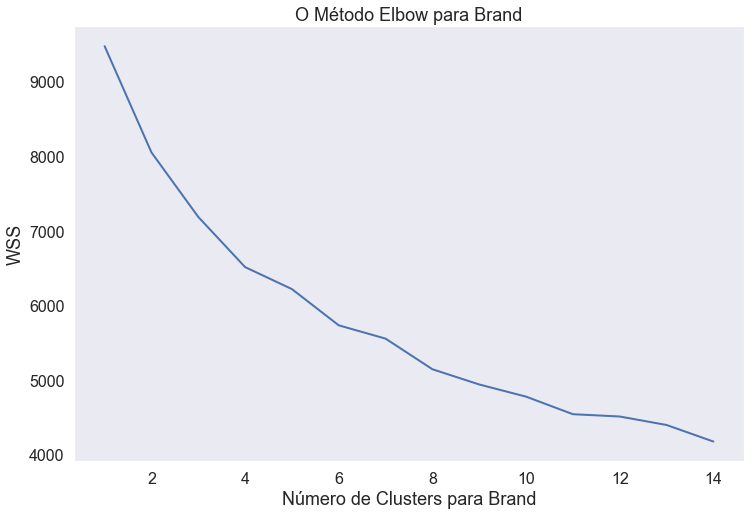

In [50]:
wcss = []
 
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 15), wcss)
plt.title('O Método Elbow para Brand')
plt.xlabel('Número de Clusters para Brand')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

### Pelo diagrama de Elbow é melhor que utizarmos mais de 4 clusters.... Pelo menos k=10